# Preparation

## Import modules

In [1]:
%load_ext autoreload
%autoreload 1
%aimport thesis_utils

In [2]:
import copy
import math
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from pandas import DataFrame
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import KFold
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader, Dataset, Subset

import thesis_utils.datastruc as tuds
import thesis_utils.models as tumod

## Configuration

In [ ]:
# Config for saving outputs
SAVE_ENABLED = True
SERIAL_NUMBER = "NOT_SET"

# Model parameters
SEQ_LEN = 10
HORIZON = 1
BATCH_SIZE = 128
NUM_EPOCHS = 25
HIDDEN_SIZE = 128
N_LAYERS = 3
DROPOUT = 0.3

# Train parameters
TARGET = "EXPORT_centered"
FEATURES = [
  "GDP_reporter",
  "GDP_partner",
  "distw", "sanction",  # sanctions categorical
  "contig", "comlang_off", "colony", "smctry",  # dist cepii categorical
]
N_SPLITS = 5
PATIENCE = 5
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.01
RANDOM_SEED = 16
KEEP_FRAC = 1.0
N_LAGS = 5
SUBSAMPLE_ENABLED = False
N_DYADS = 5000

EPS = 1e-19

SANCTION_COLS = ["arms", "military", "trade", "travel", "other"]

# Torch config
torch.manual_seed(RANDOM_SEED)
device = (
  torch.device("mps") if torch.backends.mps.is_available()
  else torch.device("cpu")
)

## Load Data

In [4]:
processed = pd.read_parquet(path="../../data/model/processed.parquet", engine="fastparquet")
df: DataFrame = processed.copy(deep=True)

### Sort, shift and compute data

In [5]:
# Sort data by Report + Partner + Year
df["dyad_id"] = df["ISO3_reporter"] + "_" + df["ISO3_partner"]
df = df.sort_values(by=["dyad_id", "Year"], ignore_index=True)

In [6]:
if SUBSAMPLE_ENABLED:
  dyad_subsample = pd.Series(df["dyad_id"].unique()).sample(n=N_DYADS, random_state=RANDOM_SEED, replace=False)
  df = df[df["dyad_id"].isin(dyad_subsample)]
print(df["dyad_id"].nunique())

5000


In [7]:
df["sanction"] = (df[SANCTION_COLS]
                  .sum(axis=1)).astype(int)

In [8]:
num_cols = ["distw", "GDP_reporter", "GDP_partner", "sanction", "contig",
            "comlang_off", "colony", "smctry", "Year", ]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").astype(float)
df = df.dropna(subset=num_cols)

In [9]:
df["Year"] = df["Year"].astype(int)
for col in ["dyad_id"]:
  df[col] = pd.Categorical(df[col], categories=sorted(df[col].unique()))

In [10]:
center_columns = ["distw", "GDP_reporter", "GDP_partner", "EXPORT"]
for col in center_columns:
  col_max = df[col].max()
  col_min = df[col].min()
  df[col + "_centered"] = (df[col] - col_min) / (col_max - col_min) - 0.5

In [11]:
# To each element in the FEATURE list add _centered
FEATURES += [f"{feature}_centered" for feature in center_columns]
for col in center_columns:
  if col == "EXPORT":
    continue
  FEATURES.remove(col)
FEATURES.remove("EXPORT_centered")

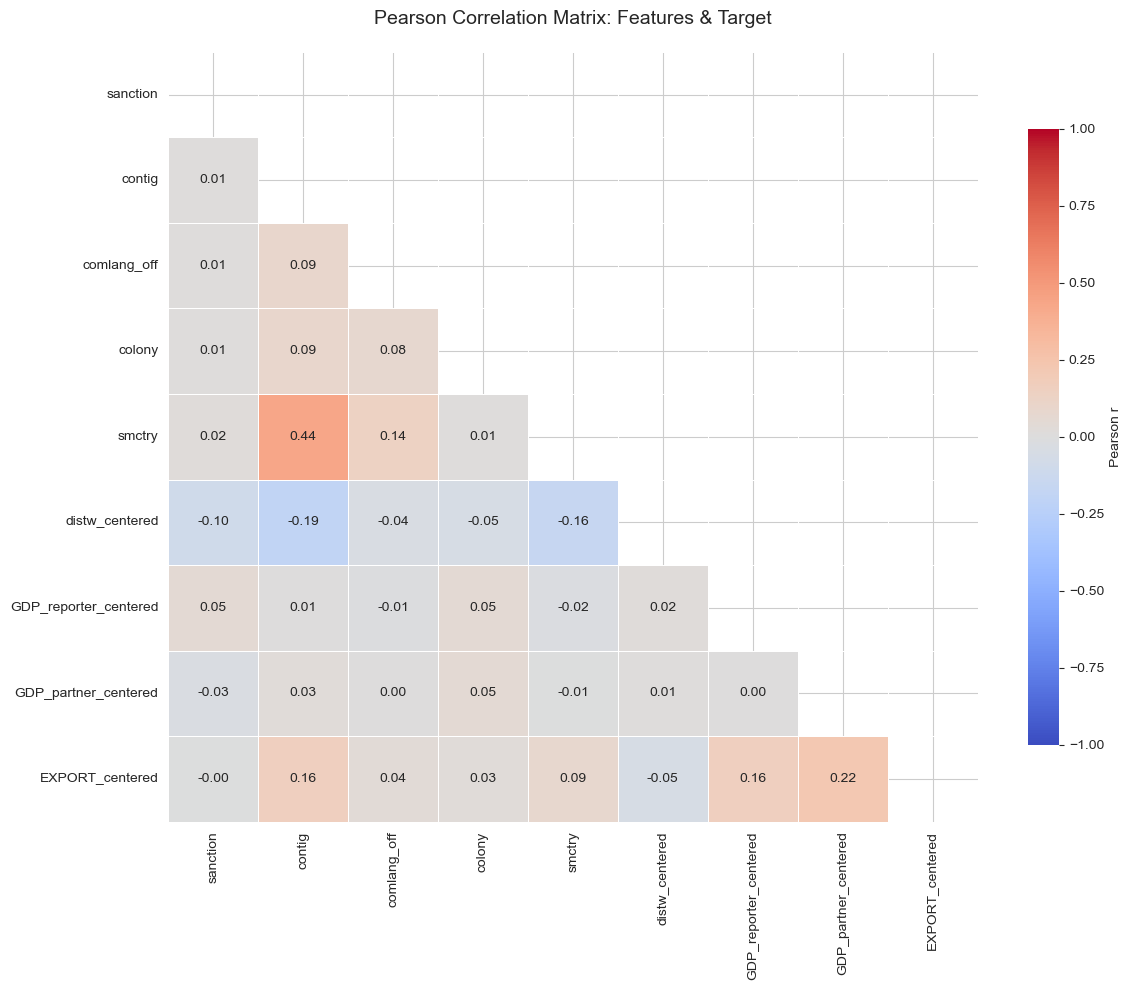

In [12]:
df_corr_input = df[FEATURES + [TARGET]].copy()
df_corr_input = df_corr_input.apply(pd.to_numeric, errors="coerce")
corr = df_corr_input.corr(method="pearson")

# --- 4. Plot heat-map -------------------------------------------------------
plt.figure(figsize=(12, 10))
# Show only one triangle to avoid duplicate information
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
  corr,
  mask=mask,
  annot=True,  # write the coefficients
  fmt=".2f",
  cmap="coolwarm",  # diverging blue–red palette
  vmin=-1, vmax=1,
  linewidths=0.5,
  cbar_kws={ "shrink": 0.8, "label": "Pearson r" }
)

plt.title("Pearson Correlation Matrix: Features & Target", pad=20, fontsize=14)
plt.tight_layout()
plt.show()

## Split data

In [13]:
# Embeddings
dyad_to_idx = { dyad: i for i, dyad in enumerate(df["dyad_id"].cat.categories) }
df["dyad_idx"] = df["dyad_id"].map(dyad_to_idx).astype(int)

In [14]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_idx, test_idx = next(gss.split(df, groups=df["dyad_id"]))
test_df = df.iloc[test_idx]
train_df = df.iloc[train_idx]

train_idx, val_idx = next(gss.split(train_df, groups=train_df["dyad_id"]))
val_df = train_df.iloc[val_idx]
train_df = train_df.iloc[train_idx]

In [15]:
train_df.loc[:, FEATURES] = train_df.loc[:, FEATURES].astype(
  "float32",
  copy=False
)

# Train

## Define Fold and Epoch steps
_For reusability_

In [16]:
# Create KFold object
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

In [17]:
# Define epoch step
def epoch_step(model: nn.Module, optimizer: Optimizer, criterion: nn.Module,
               scheduler: LRScheduler, train_loader: DataLoader, val_loader: DataLoader,
               device: any) -> float:
  model.train()
  for X, y, di in train_loader:
    X, y, di = map(lambda t: t.to(device, non_blocking=True), (X, y, di))
    optimizer.zero_grad()
    loss = criterion(model(X, di), y)
    loss.backward()
    optimizer.step()

  model.eval()
  val_losses = []
  with (torch.no_grad()):
    for X, y, di in val_loader:
      X, y, di = map(lambda t: t.to(device, non_blocking=True), (X, y, di))
      val_losses.append(criterion(model(X, di), y).item())

  val_rmse = math.sqrt((sum(val_losses) / len(val_losses)))
  scheduler.step(val_rmse)
  return val_rmse

In [18]:
# Define fold step
def fold_step(fold: int, train_idx: List, val_idx: List,
              dataset: Dataset, batch_size: int, num_epochs: int, patience: int,
              model: nn.Module, device: any,
              optimizer: Optimizer, criterion: nn.Module, scheduler: LRScheduler) -> (float, dict):
  train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=True
  )

  val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=batch_size,
    shuffle=False,
    num_workers=10,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=False
  )

  best_state = copy.deepcopy(model.state_dict())
  best_rmse = float("inf")
  patience_left = patience

  for epoch in range(num_epochs):
    val_rmse = epoch_step(model=model, optimizer=optimizer, criterion=criterion,
                          scheduler=scheduler, train_loader=train_loader, val_loader=val_loader,
                          device=device)
    print(f"Epoch {epoch + 1:02d}/{num_epochs}  |  val RMSE: {val_rmse:.4f}")

    if val_rmse < best_rmse - 1e-4:
      best_rmse, patience_left = val_rmse, 10
      best_state = model.state_dict()
    else:
      patience_left -= 1
      if patience_left == 0:
        print("Early stop.")
        break
  model.load_state_dict(best_state)
  model.eval()
  preds, truth = [], []
  with torch.no_grad():
    for X, y, di in val_loader:
      X, di = map(lambda t: t.to(device, non_blocking=True), (X, di))
      preds.append(model(X, di).cpu())
      truth.append(y)
  preds = torch.cat(preds).numpy()
  truth = torch.cat(truth).numpy()

  rmse = np.sqrt(((preds - truth) ** 2).mean())
  mae = np.abs(preds - truth).mean()
  r2 = 1 - ((preds - truth) ** 2).sum() / ((truth - truth.mean()) ** 2).sum()
  print(f" Fold {fold}  RMSE {rmse:.4f} | MAE {mae:.4f} | R² {r2:.4f}")

  return rmse, copy.deepcopy(best_state)


## Raw dataset

### Split dataset

In [19]:
dataset, dyad_to_idx = tuds.make_panel_datasets_dyad(
  data=df,
  features=FEATURES,
  target=TARGET,
  horizon=HORIZON,
)

In [20]:
# Create DataLoaders for the 3 sets
train_loader = DataLoader(
  Subset(dataset, train_idx),
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=10,
  persistent_workers=True,
  prefetch_factor=2,
  pin_memory=False
)

val_loader = DataLoader(
  Subset(dataset, val_idx),
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=10,
  persistent_workers=True,
  prefetch_factor=2,
  pin_memory=False
)

test_loader = DataLoader(
  Subset(dataset, test_idx),
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=10,
  persistent_workers=True,
  prefetch_factor=2,
  pin_memory=False
)

In [21]:
def random_walk_next_year(
    train: pd.DataFrame,
    test: pd.DataFrame,
    target_change: str,  # e.g. 'dlog_TOTAL'
    *,
    year_col: str = "Year",
    id_cols: list[str] | None = None,
):
  train = train.copy()
  test = test.copy()
  order_cols = (id_cols or []) + [year_col]
  train.sort_values(order_cols, inplace=True)
  test.sort_values(order_cols, inplace=True)

  if id_cols:
    test["y_pred"] = test.groupby(id_cols)[target_change].shift(1)
  else:
    test["y_pred"] = test[target_change].shift(1)

  mask = test["y_pred"].notna()
  test_valid = test.loc[mask]

  if test_valid.empty:
    raise ValueError("No test rows have a lagged value to predict with.")

  y_true = test_valid[target_change]
  y_pred = test_valid["y_pred"]

  results = {
    "index": test_valid.index,
    "y_true": y_true.values,
    "y_pred": y_pred.values,
    "mae": np.abs(y_pred - y_true).mean(),
    "rmse": np.sqrt(((y_pred - y_true) ** 2).mean()),
    "r2": 1 - ((y_pred - y_true) ** 2).sum() / ((y_true - y_true.mean()) ** 2).sum(),
  }
  return results

In [22]:
results_rw = random_walk_next_year(
  train=train_df,  # not actually used, but keeps call symmetric
  test=test_df,
  target_change=TARGET,
  year_col="Year",
  id_cols=["dyad_id"],
)

print("Random-walk MAE:", results_rw["mae"])
print("Random-walk RMSE:", results_rw["rmse"])
print("Random-walk R²:", results_rw["r2"])

Random-walk MAE: 9.868856245552072e-05
Random-walk RMSE: 0.000814196426293759
Random-walk R²: 0.9689291130939


/var/folders/wz/kf7643gn3_s2867t_nnc9zxc0000gn/T/ipykernel_40453/2529560120.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test["y_pred"] = test.groupby(id_cols)[target_change].shift(1)


### Train model

In [23]:
# Save config
SAVE_ENABLED = False
SERIAL_NUMBER = f"BasicGRU-RawData"

In [24]:
# Save best train iteration
best_fold_state = None
best_fold_rmse = float("inf")

In [25]:
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset))), 1):
  model = tumod.DyadGRU(
    n_features=len(FEATURES),
    n_layers=N_LAYERS,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    horizon=HORIZON,
    n_dyads=len(dyad_to_idx),
    embed_dim=32
  ).to(device=device)

  criterion = nn.MSELoss()
  optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=PATIENCE
  )

  print(f"=== FOLD {fold}/{N_SPLITS} ===")
  fold_rmse, best_state = fold_step(fold=fold,
                                    train_idx=train_idx,
                                    val_idx=val_idx,
                                    dataset=dataset,
                                    batch_size=BATCH_SIZE,
                                    num_epochs=NUM_EPOCHS,
                                    patience=PATIENCE,
                                    model=model,
                                    device=device,
                                    optimizer=optimizer,
                                    criterion=criterion,
                                    scheduler=scheduler)
  if fold_rmse < best_fold_rmse:
    best_fold_rmse = fold_rmse
    best_fold_state = copy.deepcopy(best_state)

=== FOLD 1/5 ===
Epoch 01/25  |  val RMSE: 0.0085
Epoch 02/25  |  val RMSE: 0.0174
Epoch 03/25  |  val RMSE: 0.0055
Epoch 04/25  |  val RMSE: 0.0073
Epoch 05/25  |  val RMSE: 0.0058
Epoch 06/25  |  val RMSE: 0.0053
Epoch 07/25  |  val RMSE: 0.7191
Epoch 08/25  |  val RMSE: 0.0060
Epoch 09/25  |  val RMSE: 0.0059
Epoch 10/25  |  val RMSE: 0.0057
Epoch 11/25  |  val RMSE: 0.0059
Epoch 12/25  |  val RMSE: 0.0060
Epoch 13/25  |  val RMSE: 0.0081
Epoch 14/25  |  val RMSE: 0.0062
Epoch 15/25  |  val RMSE: 0.0066
Epoch 16/25  |  val RMSE: 0.0082
Early stop.
 Fold 1  RMSE 0.0082 | MAE 0.0066 | R² -0.9887
=== FOLD 2/5 ===
Epoch 01/25  |  val RMSE: 0.0158
Epoch 02/25  |  val RMSE: 0.0115
Epoch 03/25  |  val RMSE: 0.0096
Epoch 04/25  |  val RMSE: 0.0100
Epoch 05/25  |  val RMSE: 0.0100
Epoch 06/25  |  val RMSE: 0.3027
Epoch 07/25  |  val RMSE: 0.0140
Epoch 08/25  |  val RMSE: 0.0117
Epoch 09/25  |  val RMSE: 0.0123
Epoch 10/25  |  val RMSE: 0.0108
Epoch 11/25  |  val RMSE: 0.0109
Epoch 12/25  |  

## Lagged features